Tomer Oron          322549312
Arielle Ruth Arabov 209881531


# Advanced Topics in Machine Learning for Computational Biology

## Homework 2: Antimicrobial Property prediction with tree ensembles and graph neural networks


Figure and data from: A Deep Learning Approach to Antimicrobial Discovery, Stokes et al. Cell 2020.


 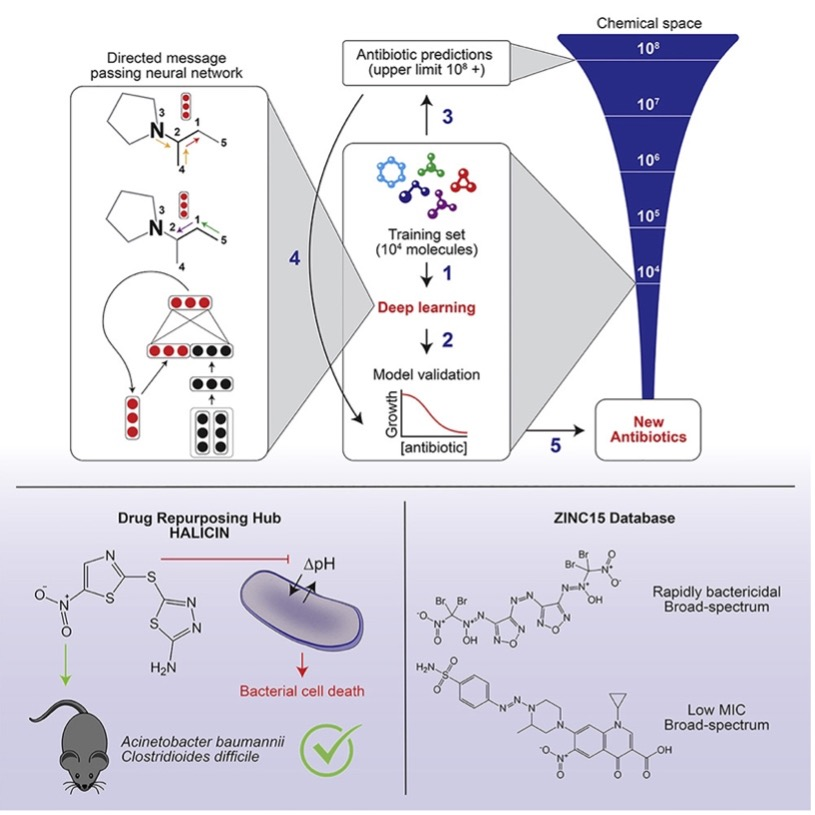





## Download data & install packages

In [ ]:

!wget https://github.com/jertubiana/jertubiana.github.io/raw/master/misc/MLCB_2024_HW2_Data.zip
!unzip /content/MLCB_2024_HW2_Data.zip
!pip install matplotlib seaborn shap torch_geometric rdkit

# Package & data loading

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from rdkit import Chem

table_first_round_molecules   =  pd.read_excel( '/content/MLCB_2024_HW2_Data/training_table.xlsx',skiprows=1,sheet_name='S1B')

table_first_round_molecules['Class_Label'] = table_first_round_molecules['Activity'].map(lambda x: 1 if x=='Active' else 0)

print( 'Training table') # This dataset was collected in the first experimental round and will be used for training/evaluating the performance of our model.
display(table_first_round_molecules.head())


table_evaluation_molecules = pd.read_excel('/content/MLCB_2024_HW2_Data/DrugRepurposing_Hub_predictions.xlsx',skiprows=1,sheet_name='S2B').drop(columns=['Unnamed: 6','Broad_ID'])
print( 'Evaluation table') # This dataset was used for screening candidates in the second experimental round. We will use it for inference only.
display(table_evaluation_molecules.head())


# Part 0: Parsing the data into Tabular Machine Learning format using the RDKIT package

In this section we:
- Convert each SMILE into a RDKIT Molecule class instance, which has many useful methods.

- Calculate various physio-chemical features for each molecule using RDKIT pre-provided functions. Example of features include number of atoms and bonds of each type, number of hydrogen bond donor and acceptors, etc.


In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, Crippen, MolSurf
import numpy as np


def extract_chemical_features(list_molecules):
  def num_atoms(mol):
    atom_counts = {
        'Total': 0,
        'Carbon': 0,
        'Nitrogen': 0,
        'Oxygen': 0,
        'Sulfur': 0,
        'Fluorine': 0,
        'Phosphate':0,
        'Chlorine':0,
        'Other':0,
    }
    for atom in mol.GetAtoms():
      atom_counts['Total'] +=1
      atom_type = atom.GetSymbol()
      if atom_type == 'C':
          atom_counts['Carbon'] += 1
      elif atom_type == 'N':
          atom_counts['Nitrogen'] += 1
      elif atom_type == 'O':
          atom_counts['Oxygen'] += 1
      elif atom_type == 'S':
          atom_counts['Sulfur'] += 1
      elif atom_type == 'F':
          atom_counts['Fluorine'] += 1
      elif atom_type == 'P':
          atom_counts['Phosphate'] += 1
      elif atom_type == 'Cl':
          atom_counts['Chlorine'] += 1
      else:
          atom_counts['Other'] += 1
    return atom_counts


  def num_bonds(mol):
    bond_counts = {
        'Total': 0,
        'Single': 0,
        'Double': 0,
        'Triple': 0,
        'Aromatic': 0,
    }
    # Iterate through all bonds in the molecule
    for bond in mol.GetBonds():
      bond_counts['Total'] +=1
      bond_type = bond.GetBondType()
      if bond_type == Chem.BondType.SINGLE:
          bond_counts['Single'] += 1
      elif bond_type == Chem.BondType.DOUBLE:
          bond_counts['Double'] += 1
      elif bond_type == Chem.BondType.TRIPLE:
          bond_counts['Triple'] += 1
      elif bond_type == Chem.BondType.AROMATIC:
          bond_counts['Aromatic'] += 1
    return bond_counts


  """
  Extract chemical features for a list of molecules.

  Parameters:
  list_molecules (list): List of small molecules (RDKIT class instances).
  Returns:
  pandas.DataFrame: Table of descriptors.
  """

  # List to store results
  results = []

  # Define descriptors to compute (MOE-like)
  descriptors = {
      'MolWt': Descriptors.MolWt,  # Molecular weight
      'LogP': Crippen.MolLogP,     # Octanol-water partition coefficient
      'TPSA': MolSurf.TPSA,        # Topological polar surface area
      'HBD': Lipinski.NumHDonors,  # Number of hydrogen bond donors
      'HBA': Lipinski.NumHAcceptors,  # Number of hydrogen bond acceptors
      'RotBonds': Lipinski.NumRotatableBonds,  # Number of rotatable bonds
      'NumAromRings': Descriptors.NumAromaticRings,  # Number of aromatic rings
      'NumHeteroatoms': Descriptors.NumHeteroatoms,  # Number of heteroatoms
      'FractionSP3': Descriptors.FractionCSP3,  # Fraction of sp3 carbons
      'MolarRefractivity': Crippen.MolMR,  # Molar refractivity (MOE's mr)
      'NumAtoms': num_atoms,
      'NumBonds': num_bonds,
  }

  all_mol_features = []
  for molecule in list_molecules:
    mol_features = {}
    for desc_name, desc_func in descriptors.items():
      results = desc_func(molecule)
      if isinstance(results,dict):
        for key, value in results.items():
          mol_features[f'{desc_name}{key}'] = value
      else:
        mol_features[desc_name] = results
    all_mol_features.append(mol_features)
  return pd.DataFrame(all_mol_features)




# SMILES is a string-based representation of molecules.
first_round_molecules_smiles = table_first_round_molecules['SMILES']
evaluation_molecules_smiles = table_evaluation_molecules['SMILES']

# We first turn each molecule into an instance of the RDKIT molecule.
first_round_molecules_rdkit = [Chem.MolFromSmiles(smiles) for smiles in first_round_molecules_smiles]
evaluation_molecules_rdkit = [Chem.MolFromSmiles(smiles) for smiles in evaluation_molecules_smiles]

# Discard examples for which conversion failed.
first_round_molecules_success = [i for i in range(len(first_round_molecules_rdkit)) if first_round_molecules_rdkit[i] is not None]
evaluation_molecules_success = [i for i in range(len(evaluation_molecules_rdkit)) if evaluation_molecules_rdkit[i] is not None]

print(f'Molecule construction failed for { len(first_round_molecules_rdkit)-len(first_round_molecules_success) }/{len(first_round_molecules_rdkit)} examples in the first round dataset')
print(f'Molecule construction failed for {len(evaluation_molecules_rdkit) - len(evaluation_molecules_success)}/{len(evaluation_molecules_rdkit)} examples in the evaluation dataset')

table_first_round_molecules = table_first_round_molecules.iloc[first_round_molecules_success].reset_index()
table_evaluation_molecules = table_evaluation_molecules.iloc[evaluation_molecules_success].reset_index()

first_round_molecules_rdkit = [mol for mol in first_round_molecules_rdkit if mol is not None]
evaluation_molecules_rdkit = [mol for mol in evaluation_molecules_rdkit if mol is not None]


features_first_round_molecules = extract_chemical_features(first_round_molecules_rdkit)
features_first_round_molecules.index = table_first_round_molecules['Name']

features_evaluation_molecules = extract_chemical_features(evaluation_molecules_rdkit)
features_evaluation_molecules.index = table_evaluation_molecules['Name']

print('Example of descriptors for 10 molecules')
display(features_first_round_molecules.head())






# Part I: Exploratory Data Analysis

1.	Display, as a scatter plot, the distribution of the number of atoms and covalent bonds per molecule. Color by the measured  class. Is there a relationship between molecule size and activity?

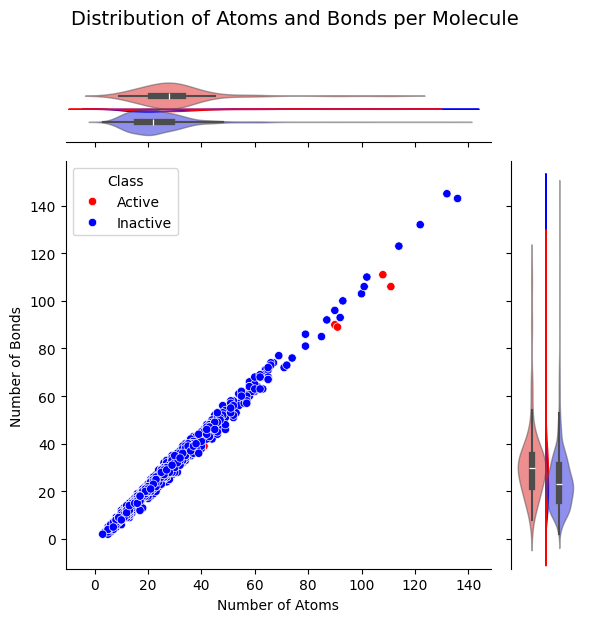

In [ ]:
features = features_first_round_molecules.reset_index(drop=True)
table = table_first_round_molecules.reset_index(drop=True)

# Combine the features and labels
combined_df = features.copy()
combined_df['Class_Label'] = table['Class_Label']
combined_df['Class'] = combined_df['Class_Label'].map({1: 'Active', 0: 'Inactive'})

# Set color palette
palette = {'Active': 'red', 'Inactive': 'blue'}

# Create a joint plot with marginal violin plots
g = sns.jointplot(
    data=combined_df,
    x='NumAtomsTotal',
    y='NumBondsTotal',
    hue='Class',
    kind='scatter',
    palette=palette,
    marginal_kws=dict(common_norm=False),
    height=6
)

# Add marginal violins manually (seaborn < 0.12 doesn't support this directly in jointplot)
# So here's a workaround for older versions:
g.plot_marginals(sns.violinplot, hue='Class', palette=palette, alpha=0.5, linewidth=1, dodge=True)

# Set axis labels and title
g.set_axis_labels("Number of Atoms", "Number of Bonds")
plt.suptitle("Distribution of Atoms and Bonds per Molecule", fontsize=14, y=1.03)

plt.tight_layout()
plt.show()

Preforming MANOVA, and logistic regression:

In [ ]:
from statsmodels.multivariate.manova import MANOVA
import statsmodels.api as sm


combined_df['Class'] = combined_df['Class'].astype(str)

manova = MANOVA.from_formula('NumAtomsTotal + NumBondsTotal ~ Class', data=combined_df)
print(manova.mv_test())


print("\n"*10)

X = combined_df[['NumAtomsTotal', 'NumBondsTotal']]
X = sm.add_constant(X)
y = (combined_df['Class'] == 'Active').astype(int)

model = sm.Logit(y, X).fit()
print(model.summary())



                   Multivariate linear model
                                                               
---------------------------------------------------------------
       Intercept        Value  Num DF   Den DF  F Value  Pr > F
---------------------------------------------------------------
          Wilks' lambda 0.7479 2.0000 2331.0000 392.8633 0.0000
         Pillai's trace 0.2521 2.0000 2331.0000 392.8633 0.0000
 Hotelling-Lawley trace 0.3371 2.0000 2331.0000 392.8633 0.0000
    Roy's greatest root 0.3371 2.0000 2331.0000 392.8633 0.0000
---------------------------------------------------------------
                                                               
---------------------------------------------------------------
          Class          Value  Num DF   Den DF  F Value Pr > F
---------------------------------------------------------------
           Wilks' lambda 0.9817 2.0000 2331.0000 21.7040 0.0000
          Pillai's trace 0.0183 2.0000 2331.0000 21.7040 0.

Given that in our opinion the plot wasn't clear enough to indicate the relationship in question, we decided to perform MANOVA and logistic regression in order to obtain more statistically accurate understanding. The MANOVA results show a statistically significant effect of molecular class (active vs. inactive) on the combined number of atoms and bonds (Wilks' lambda = 0.9817, p < 0.0001), indicating that molecular size distributions differ slightly but consistently between classes. The logistic regression confirms this with a small but significant positive coefficient for number of atoms (p = 0.017) and a non-significant negative coefficient for number of bonds (p = 0.059). Together with the plot, these results suggest that while molecular size alone (atoms and bonds) is not a strong predictor of activity (low pseudo R² = 0.03), it does have a measurable and statistically valid association with it. Therfore, further exploration alongside other chemical features is necessary.

2.	For each of the following five features:
*   Octanol-water partition coefficient
*   Molecular weight
*   Number of hydrogen bond donors
*   Number of hydrogen bond acceptors
*   Number of aromatic rings


Display the histogram of the feature value, for each of the two classes. Which feature(s) have the strongest discriminative power?


Feature-wise Statistics:
Feature                                   F-statistic      p-value         KS-p
-------------------------------------------------------------------------------------
Octanol-water partition coefficient           55.2226    1.502e-13     1.02e-06
Molecular weight                              43.9889    4.091e-11     1.16e-11
Number of hydrogen bond donors                27.3048    1.892e-07     0.001787
Number of hydrogen bond acceptors             84.0600    1.024e-19    1.529e-12
Number of aromatic rings                       2.0213       0.1552     0.007909


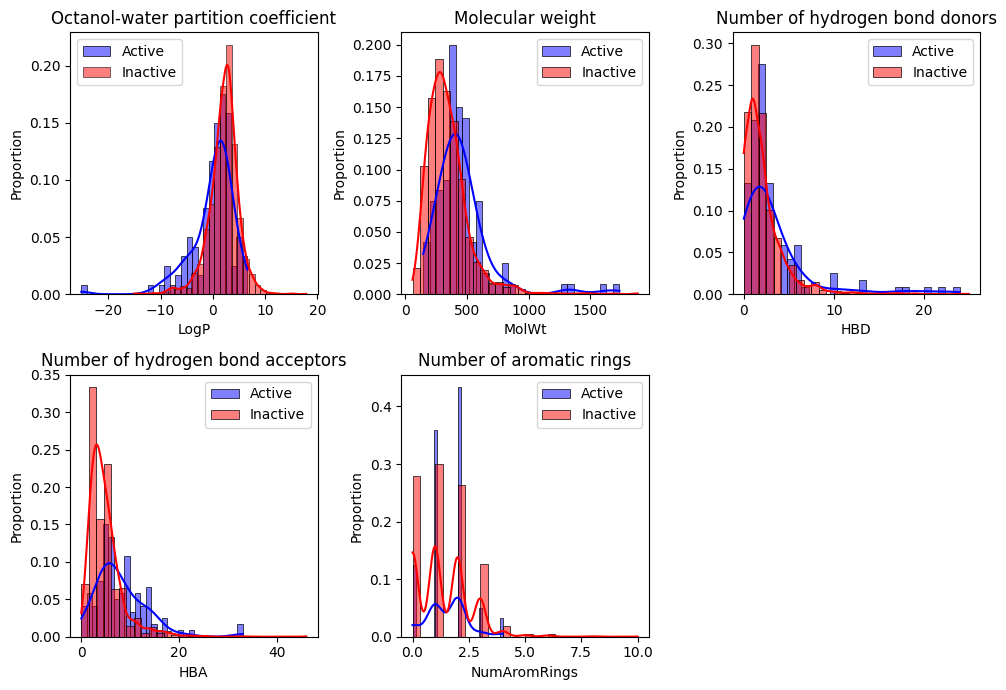

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, ks_2samp
from sklearn.preprocessing import StandardScaler

labels = combined_df["Class_Label"].values
feature_dict = {
    "Octanol-water partition coefficient": "LogP",
    "Molecular weight": "MolWt",
    "Number of hydrogen bond donors": "HBD",
    "Number of hydrogen bond acceptors": "HBA",
    "Number of aromatic rings": "NumAromRings"
}

active = combined_df[combined_df["Class_Label"] == 1]
inactive = combined_df[combined_df["Class_Label"] == 0]

plt.figure(figsize=(10, 7))
print("Feature-wise Statistics:")
print(f"{'Feature':<40} {'F-statistic':>12} {'p-value':>12} {'KS-p':>12}")
print("-" * 85)

for i, (feature_name, symbol) in enumerate(feature_dict.items()):
    # Plot histograms
    plt.subplot(2, 3, i+1)
    sns.histplot(active[symbol], label="Active", color="blue", stat="proportion", bins=30, kde=True)
    sns.histplot(inactive[symbol], label="Inactive", color="red", stat="proportion", bins=30, kde=True)
    plt.legend()
    plt.title(feature_name)
    plt.xlabel(symbol)

    # ANOVA F-test
    f_stat, p_val = f_oneway(active[symbol], inactive[symbol])

    # Kolmogorov-Smirnov test
    ks_stat, ks_pval = ks_2samp(active[symbol], inactive[symbol])

    print(f"{feature_name:<40} {f_stat:12.4f} {p_val:12.4g} {ks_pval:12.4g}")

plt.tight_layout()
plt.show()

To assess the significance of feature distribution differences between the two classes, we conducted both ANOVA and Kolmogorov-Smirnov tests. While the plots suggest that the distributions are somewhat similar, the statistical results indicate that all features except for "Number of aromatic rings" differ significantly between classes. However, it's important to note that even though these features show statistically distinct distributions, they may still have limited predictive power for classification.

# Part II: Data Partition

Our training data is NOT independently distributed because many known antimicrobial molecules were obtained by small modifications of previously known molecules. Indeed, similar molecules often have similar chemical activity. We thus need to partition the data with grouped splits.


Specifically, our goal is to build a model that can generalize well to unseen molecules. To this end, we want to make sure that our molecules from the train, validation and test are “dissimilar enough”.


We will use the Tanimoto similarity, a custom metric for calculating similarity between molecules (from 0 = dissimilar to 1 = maximally similar).



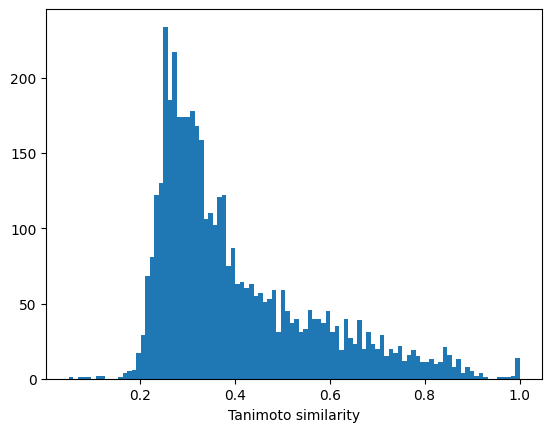

Selected Tanimoto similarity Cut-off: 0.34
Created 477 groups


In [ ]:
from rdkit.Chem import AllChem, DataStructs
from scipy.sparse import csr_array
from scipy.sparse.csgraph import connected_components
from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold
from rdkit.Chem import rdFingerprintGenerator


def calculate_morgan_fingerprints(list_molecules, radius=2, fpSize=1024):
  '''
  A count-based representation of small molecules (e.g., how many occurence of O with double bond to C, etc.)
  '''
  mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius,fpSize=fpSize)
  fingerprints = [mfpgen.GetFingerprint(mol) for mol in list_molecules]
  return fingerprints


def calculate_tanimoto_similarity(fp1,fp2):
    """
    Calculate the Tanimoto similarity between two molecules given their Morgan fingerprints.

    Parameters:
    fp1 (str): Morgan Fingerprints of the first molecule.
    fp2 (str): Morgan Fingerprints of the second molecule.

    Returns:
    float: Tanimoto similarity score (0 to 1), or None if invalid SMILES.
    """
    return DataStructs.TanimotoSimilarity(fp1, fp2)



first_round_molecules_morgan_fingerprints = calculate_morgan_fingerprints(first_round_molecules_rdkit)
evaluation_molecules_morgan_fingerprints = calculate_morgan_fingerprints(evaluation_molecules_rdkit)


nFirstRoundMols = len(first_round_molecules_rdkit)
nEvaluationMols = len(evaluation_molecules_rdkit)


tanimoto_similarities_first_round = np.zeros([nFirstRoundMols,nFirstRoundMols])


## Calculate Tanimoto similarities within set of molecules from first round.
for i in range(nFirstRoundMols):
  for j in range(i+1,nFirstRoundMols):
    tanimoto_similarities_first_round[i,j] = calculate_tanimoto_similarity(first_round_molecules_morgan_fingerprints[i],first_round_molecules_morgan_fingerprints[j])
    tanimoto_similarities_first_round[j,i] = tanimoto_similarities_first_round[i,j]


## Calculate Tanimoto similarities between set of molecules from first round and set from second round.


tanimoto_similarities_evaluation_to_first_round = np.zeros([nEvaluationMols,nFirstRoundMols])
for i in range(nEvaluationMols):
  for j in range(nFirstRoundMols):
    tanimoto_similarities_evaluation_to_first_round[i,j] = calculate_tanimoto_similarity(evaluation_molecules_morgan_fingerprints[i],first_round_molecules_morgan_fingerprints[j])


## Explain this code section for Q4/5.

similarity_to_closest_labeled_molecule = tanimoto_similarities_evaluation_to_first_round.max(axis=1)
plt.hist(similarity_to_closest_labeled_molecule,bins=100)
plt.xlabel('Tanimoto similarity')
plt.show()

tanimoto_cut_off = np.median(similarity_to_closest_labeled_molecule)
print(f'Selected Tanimoto similarity Cut-off: {tanimoto_cut_off:.2f}')


binary_similarity_graph = tanimoto_similarities_first_round >= tanimoto_cut_off
n_groups, groups = connected_components(csgraph=csr_array(binary_similarity_graph), directed=False, return_labels=True)

print(f'Created {n_groups} groups')


train_test_split = GroupShuffleSplit(n_splits=1,test_size=0.2,random_state=0)
[(train_and_val_index, test_index)] = train_test_split.split(features_first_round_molecules,table_first_round_molecules['Class_Label'],groups)



## Use this train/val split for training the GNN.
train_val_split = GroupShuffleSplit(n_splits=1,test_size=0.2,random_state=0)
[(train_index, val_index)] = train_val_split.split(features_first_round_molecules.iloc[train_and_val_index],table_first_round_molecules['Class_Label'].iloc[train_and_val_index],groups[train_and_val_index])


## Use this 5-fold cross-validation for training and evaluating the feature-based model.

cross_val_split = StratifiedGroupKFold(n_splits=5,shuffle=True,random_state=0)

cv_indices = list( cross_val_split.split(features_first_round_molecules.iloc[train_and_val_index], table_first_round_molecules['Class_Label'].iloc[train_and_val_index], groups[train_and_val_index]) )


3.	Justify the choice of threshold used for Tanimoto similarity.

We use the evaluation molecules as an external reference group to understand what typical structural similarity looks like for the first-round molecules. For each first-round molecule, we calculate the highest Tanimoto similarity it shares with any evaluation molecule. The median of these maximum similarities is then used as the cutoff. This threshold is not too conservative, so it allows grouping of reasonably similar molecules, but it still requires some structural similarity, ensuring that the groups formed are meaningful. This balances the need for chemical similarity with the goal of avoiding overly strict separation.


4.	Explain how the algorithm prevents two molecules with high Tanimoto similarity from ending up in the same split.

We create groups of molecules based on their structural similarity to prevent highly similar molecules from being split across training validation and testing sets. To do this, we first compute pairwise Tanimoto similarities between all first-round molecules. Using the cutoff derived from the median similarity to the evaluation molecules, we build a graph where edges represent pairs of molecules with similarity above this threshold. We then identify connected components in this graph, which correspond to groups of highly similar molecules. When performing the data splits, these groups are kept intact, ensuring that molecules with high Tanimoto similarity remain together in either the training validation or test split. This approach prevents data leakage caused by splitting chemically similar molecules across different sets, maintaining a realistic evaluation of model performance.

# Part III: Training a tree ensemble model on the Dataset.

5.	 Throughout the rest of the homework, the metric for model selection and evaluation is chosen to be the Area under the Precision Recall Curve (implemented as the “average_precision_score” in sklearn). Justify this choice of metric given the problem considered.


In the context of our problem, where the dataset is highly imbalanced with far fewer active compounds than inactive ones, AUCPR is a more appropriate evaluation metric than accuracy or AUROC. Unlike these traditional metrics which can be misleading under class imbalance, AUCPR directly captures the trade-off between precision and recall. This is especially important in high-stakes applications like drug discovery, where false positives carry a significant cost. Advancing a non-effective compound into clinical trials incurs substantial financial and ethical consequences. Therefore, minimizing false positives by emphasizing precision becomes crucial.

6.	Using sklearn’s HistGradBoosting (or xgboost/LightGBM), build a Gradient Boosted Tree classifier. Select the optimal hyperparameters (number of iterations; learning rate; regularization strength; number of leaves) by cross-validation using the provided group split. Calculate the precision-recall curve over the test set, display it and report the AUCPR. Comment on the quality of the predictions.

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Defining train & test for convenience
X_train_val = features_first_round_molecules.iloc[train_and_val_index]
y_train_val = table_first_round_molecules['Class_Label'].iloc[train_and_val_index]
X_test = features_first_round_molecules.iloc[test_index]
y_test = table_first_round_molecules['Class_Label'].iloc[test_index]

pipeline = Pipeline([
    ('clf', HistGradientBoostingClassifier(random_state=0, class_weight='balanced')) # taking into consideration class imbalance
])

# Defining hyperparameter grid
param_grid = {
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'clf__max_iter': [200, 300, 600, 900],
    'clf__max_leaf_nodes': [31, 63, 127, 255],
    'clf__min_samples_leaf': [10, 20, 50],
    'clf__l2_regularization': [0.0, 0.1, 1.0, 5.0, 10.0]
}


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv_indices,
    scoring='average_precision',  # AUCPR as scoring metric
    n_jobs=-1,
    verbose=2
)


grid_search.fit(X_train_val, y_train_val)
best_model = grid_search.best_estimator_
y_scores = best_model.predict_proba(X_test)[:, 1]


Fitting 5 folds for each of 960 candidates, totalling 4800 fits


Best Parameters: {'clf__l2_regularization': 5.0, 'clf__learning_rate': 0.05, 'clf__max_iter': 900, 'clf__max_leaf_nodes': 31, 'clf__min_samples_leaf': 50}
Test AUCPR: 0.339 



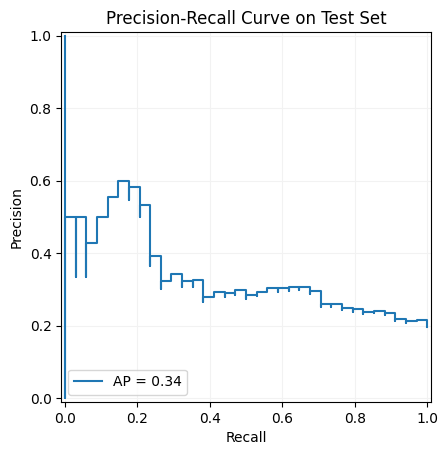

In [ ]:
print("Best Parameters:", grid_search.best_params_)

precision, recall, _ = precision_recall_curve(y_test, y_scores)
aucpr = average_precision_score(y_test, y_scores)
print(f"Test AUCPR: {aucpr:.3f} \n")

PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=aucpr).plot()
plt.title("Precision-Recall Curve on Test Set")
plt.grid(color='0.95')
plt.show()


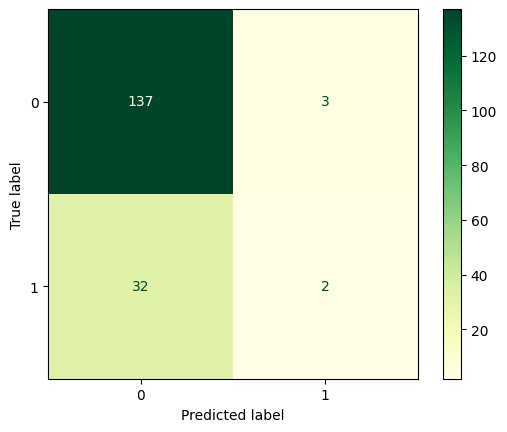

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap=plt.cm.YlGn)
plt.show()

Due to the strong class imbalance in our dataset, our classifier achieves an AUCPR of 0.34, which is better than random but still can be improved. To address this imbalance, we set the class weights parameter to 'balanced', giving higher importance to the minority class, which are the active samples. However, due to the very low percentage of active molecules, this result alone doesn't ensure that the model is making meaningful predictions.
Therefore, to validate this assumption, we also plotted the confusion matrix. At a default decision threshold of 0.5, we find that most active molecules were misclassified as inactive. This confirms that, despite the AUCPR improvement over a random baseline, the model still struggles to accurately identify active compounds, making its predictions less reliable.

# Part IV: Post-hoc explanations of the tree ensemble model

7.	Using sklearn, calculate the feature importance using the Permutation Feature Importance metric over the train and test set. Which features are the most informative?

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

result_train = permutation_importance(estimator=best_model, X=X_train_val, y=y_train_val, n_repeats=50,
                                      scoring='average_precision', random_state=0, n_jobs=-1) # scoring == AP since our entire scoring throughout is Classifer is AP as well.

result_test = permutation_importance(estimator=best_model, X=X_test, y=y_test, n_repeats=50, random_state=0,
                                     scoring='average_precision', n_jobs=-1) # scoring == AP since our entire scoring throughout is Classifer is AP as well.

feature_names = X_train_val.columns
all_importances = pd.DataFrame({
    'Features':feature_names,
    'Permutation importance: Train':result_train['importances_mean'],
    'Permutation importance: Test':result_test['importances_mean'],
}).set_index('Features')


all_importances = all_importances.sort_values(by=['Permutation importance: Test', 'Permutation importance: Train'],ascending=False) # Test permutation is more important.
all_importances = all_importances.style.background_gradient(cmap=plt.cm.YlGn, axis=0)
display(all_importances)

,Permutation importance: Train,Permutation importance: Test
Features,,
MolWt,0.006342,0.047362
NumAtomsFluorine,0.000000,0.039631
NumHeteroatoms,0.000049,0.028712
RotBonds,0.011967,0.024426
NumAtomsNitrogen,0.064613,0.019286
NumAtomsChlorine,0.021734,0.015548
NumBondsTotal,0.000000,0.013102
NumBondsDouble,0.000589,0.008118
NumAtomsOxygen,0.000179,0.007595


![Screenshot 2025-07-21 at 11.02.09 AM.png](<attachment:Screenshot 2025-07-21 at 11.02.09 AM.png>)

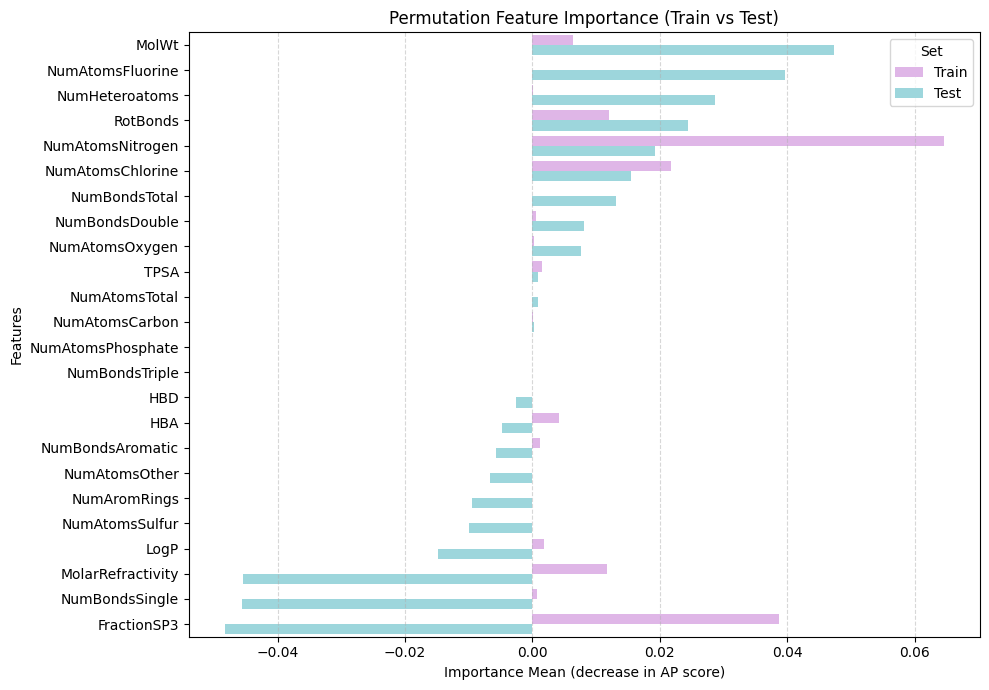

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


importance_df = all_importances.data

# reshape from wide to long format
long_df = importance_df.reset_index().melt(
    id_vars='Features',
    value_vars=['Permutation importance: Train', 'Permutation importance: Test'],
    var_name='Set',
    value_name='Importance'
)
long_df['Set'] = long_df['Set'].str.replace('Permutation importance: ', '')


custom_palette = {
    'Train': '#e4aeef',
    'Test': '#92dee6'
}


# plot using seaborn
plt.figure(figsize=(10, 7))
sns.barplot( data=long_df, y='Features', x='Importance', hue='Set', orient='h', palette=custom_palette)
plt.title('Permutation Feature Importance (Train vs Test)')
plt.xlabel('Importance Mean (decrease in AP score)')
plt.ylabel('Features')
plt.legend(title='Set')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Based on the table and the plot we can identify three notable patterns in permutation importance across train and test sets:

1. **High importance in both train and test** – very informative and high generalizable signal.
2. **High in train but low/negative in test** – suggests overfitting.
3. **High in test but low in train** – indicates that the feature was underused during training but may carry valuable signal for generalization.

Using this categorization, the most clearly important features in the dataset fall under group 1 and include **Molecular weight** and **Number of rotatable bonds**, since they show consistently high importance across both sets.

Additionally, features in group 3—such as **Number of heteroatoms**, and **Number of fluorine atoms** appear underused in training but show promise for generalization, and may indicate the need for further investigation. Lastly, **Number of nitrogen atoms** is also noteworthy, as it has the highest importance in the training set and moderate importance in the test set, making it an interesting borderline case between groups 1 and 2.


8.	Using sklearn, display the Partial Dependence Plots (PDP) for the 10 most important features, ordered by importance. Comment on the findings.

In [ ]:
top10_train = importance_df.sort_values(by='Permutation importance: Train',ascending=False).head(10).index.tolist()
top10_test = importance_df.sort_values(by='Permutation importance: Test',ascending=False).head(10).index.tolist()

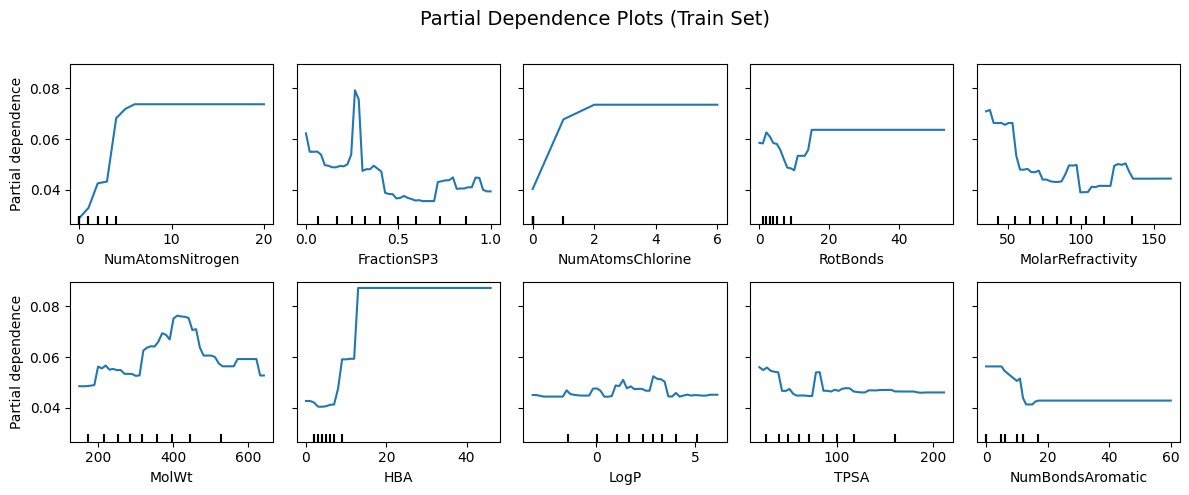

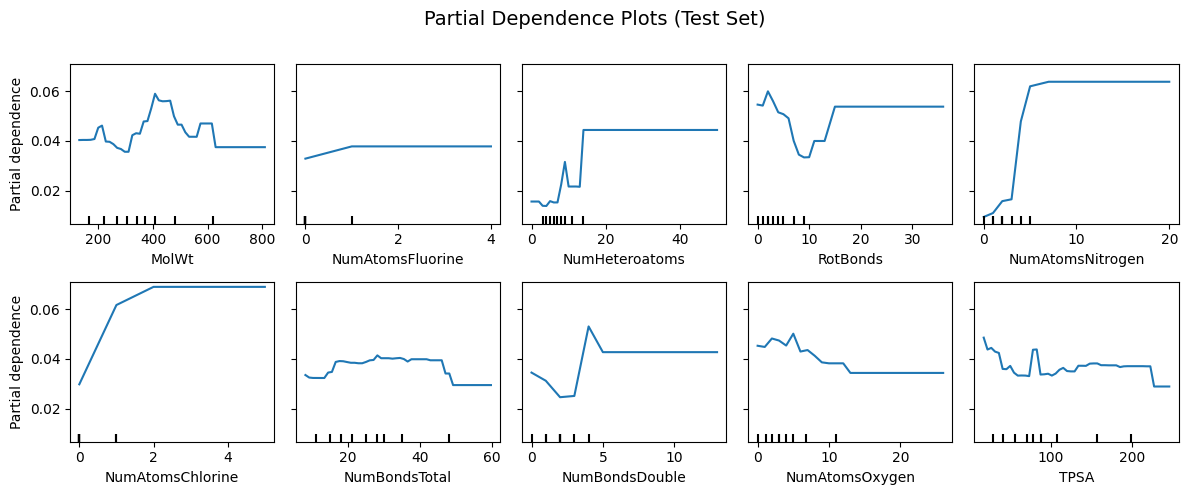

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# plot top 10 in train
fig_train, ax_train = plt.subplots(2,5, figsize=(12, 5))
PartialDependenceDisplay.from_estimator(best_model, X_train_val, features=top10_train, ax=ax_train, grid_resolution=50)
fig_train.suptitle("Partial Dependence Plots (Train Set)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


# plot top 10 in test
fig_test, ax_test = plt.subplots(2,5, figsize=(12, 5))
PartialDependenceDisplay.from_estimator(best_model,X_test,features=top10_test,ax=ax_test,grid_resolution=50)
fig_test.suptitle("Partial Dependence Plots (Test Set)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

To better understand how individual features influence the model's predictions, we generated PDPs for the top 10 features ranked by permutation importance on the training set (top figure) and on the test set (bottom figure).
Across both sets, we observe that many features have non-linear effects on the prediction outcome. This indicates that their influence on the model is not constant across their value range and a characteristic of complex relationships.
Howevrer it can be seen that there are features that have a clear monotonic relationship with the outcome:
**Number of chlorine atoms**, **number of nitrogen atoms** and **HBA** show a positive monotonic trend meaning that as their values increase, so does the model's predicted probability of a compound being active.


9.	Predict the activity of Halicin (SMILE representation: Nc1nnc(Sc2ncc([N+](=O)[O-])s2)s1),  Amoxicilin (SMILE representation: CC1(C)SC2C(NC(=O)C(N)c3ccc(O)cc3)C(=O)N2C1C(=O)O) and calculate the Shapley values associated to these prediction using shap. Are they predicted to be active and why?

In [ ]:
import shap

am = X_train_val.loc[['AMOXICILLIN']]
ham = features_evaluation_molecules.loc[['SU3327']]
X_query = pd.concat([am, ham])

Amoxicilin:
Predicted probability: 3.48e-03
Predicted class: 0
----------------------------------------


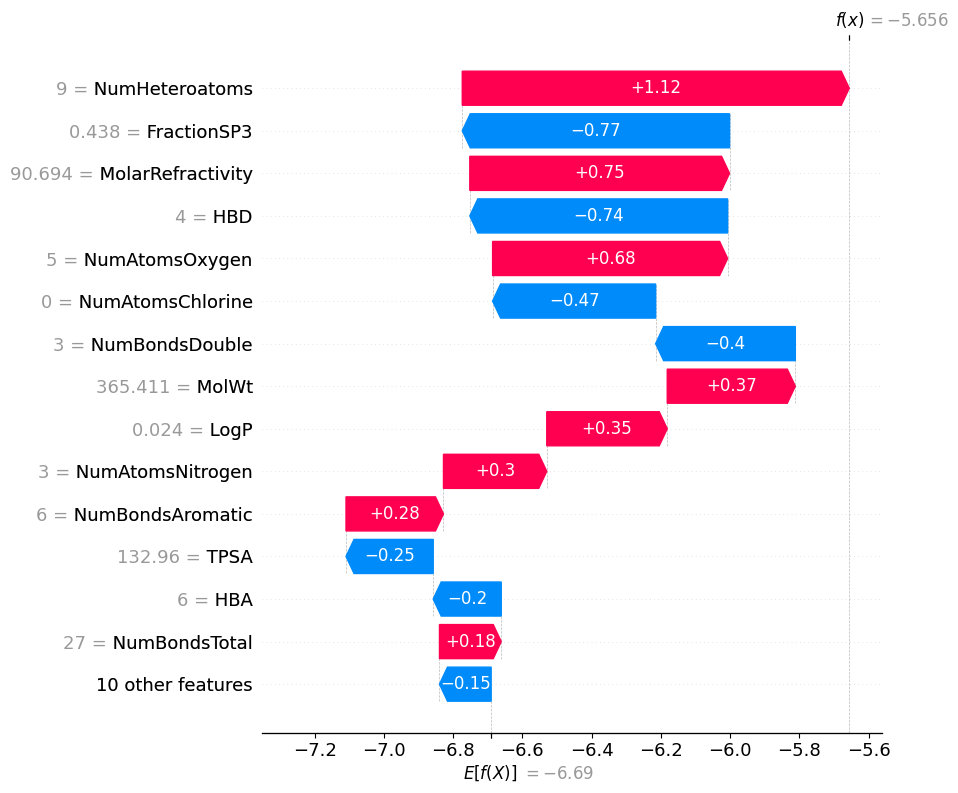



Halicin:
Predicted probability: 5.08e-01
Predicted class: 1
----------------------------------------


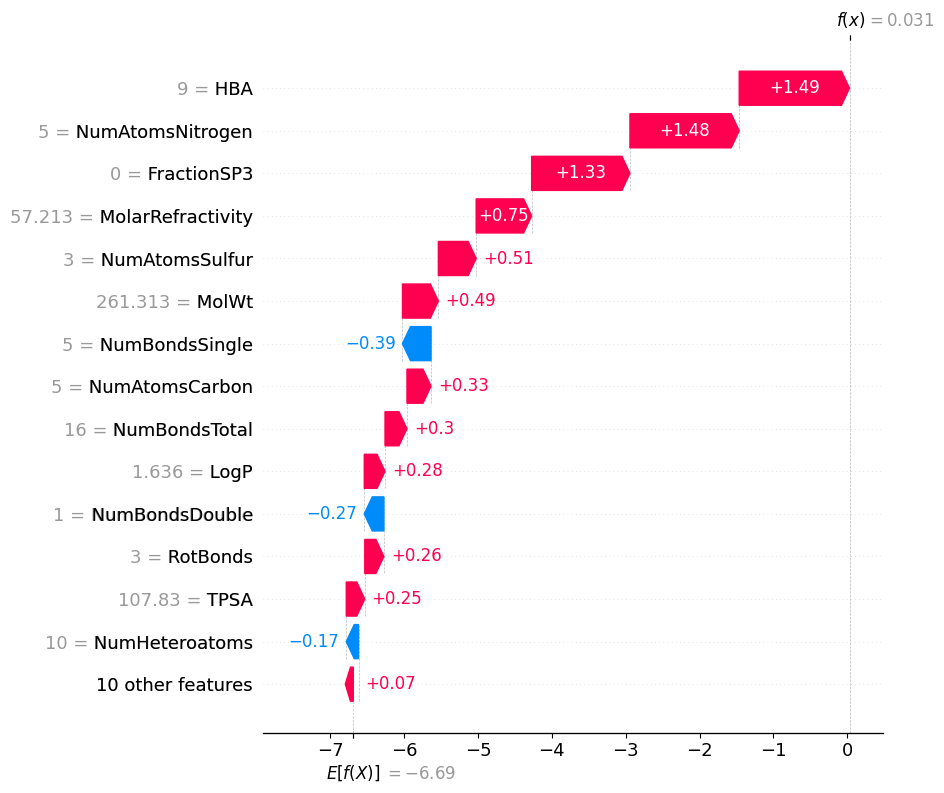

In [ ]:
import shap
import matplotlib.pyplot as plt

model = best_model.named_steps['clf']  # HistGradientBoostingClassifier

compounds_of_interest = ['Amoxicilin', 'Halicin']
y_pred_proba = model.predict_proba(X_query)[:, 1]
y_pred_class = model.predict(X_query)

# compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_query)

for i, name in enumerate(compounds_of_interest):
    print(f'{name}:')
    print("Predicted probability: {:.2e}".format(y_pred_proba[i]))
    print("Predicted class: {}".format(y_pred_class[i]))
    print("-" * 40)
    shap.plots.waterfall(shap_values[i], max_display=15)
    print("\n")

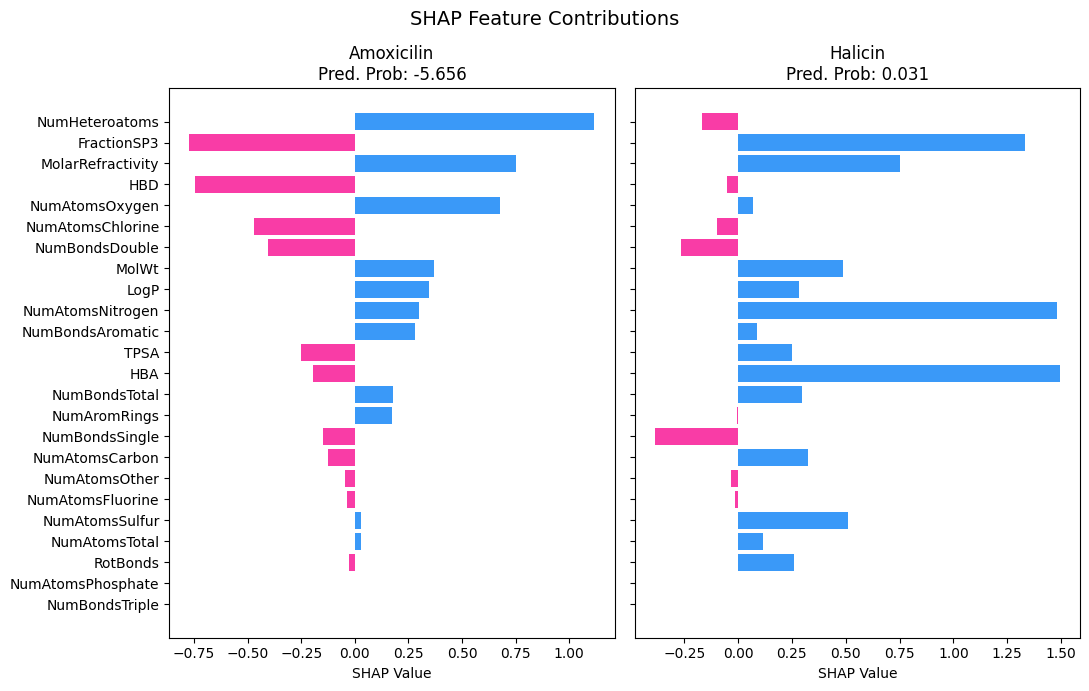

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import shap
from scipy.special import expit

features = shap_values.feature_names

# Amoxicilin (index 0)
shap_values_amoxicilin = shap_values[0].values
feature_values_amoxicilin = shap_values[0].data

# Halicin (index 1)
shap_values_halicin = shap_values[1].values
feature_values_halicin = shap_values[1].data

pred_prob_amox = -5.656
pred_prob_hal = 0.031


def build_df(name, shap_vals, feat_vals):
    df = pd.DataFrame({
        'Feature': features,
        'SHAP Value': shap_vals,
        'Feature Value': feat_vals
    })
    df['|SHAP|'] = df['SHAP Value'].abs()
    df = df.sort_values(by='|SHAP|', ascending=True)
    return df

df_amox = build_df('Amoxicilin', shap_values_amoxicilin, feature_values_amoxicilin)
df_hal = build_df('Halicin', shap_values_halicin, feature_values_halicin)
fig, axes = plt.subplots(1, 2, figsize=(11, 7), sharey=True)

# Amoxicilin
axes[0].barh(df_amox['Feature'], df_amox['SHAP Value'],
             color=['#f93ca6' if x < 0 else '#3a99f8' for x in df_amox['SHAP Value']])
axes[0].set_title(f'Amoxicilin\nPred. Prob: {pred_prob_amox:}')
axes[0].set_xlabel('SHAP Value')

# Halicin
axes[1].barh(df_hal['Feature'], df_hal['SHAP Value'],
             color=['#f93ca6' if x < 0 else '#3a99f8' for x in df_hal['SHAP Value']])
axes[1].set_title(f'Halicin\nPred. Prob: {pred_prob_hal}')
axes[1].set_xlabel('SHAP Value')

plt.suptitle('SHAP Feature Contributions', fontsize=14)
plt.tight_layout()
plt.show()


To understand the model's predictions for Amoxicilin and Halicin, we used SHAP waterfall plots and bar plots that visualize feature contributions. These explanations start from the model’s base which is −6.69. This base value reflects the model's prior belief that most molecules in the training set are inactive (which they are), so predictions begin with a strong bias toward low activity probability unless overridden by influential features.

For Amoxicilin, the final model output was −5.656, which translates into a very low predicted probability, causing the model to wrongly classify it as inactive. Many of its features pushed the prediction further negative for example, FractionSP3, HBD, and HBA. Its worth notice that only a few features like NumHeteroatoms or MolarRefractivity contributed here to a positive prediction.

In contrast, Halicin was correctly predicted as active, with a predicted probability of 0.508 (just above the 0.5 threshold). This decision was driven by several positively contributing features such as HBA and NumAtomsNitrogen.
Notably, no single feature was extremely dominant and instead a combination of moderate positive contributions across chemically meaningful descriptors helped the model reach the correct prediction.

Interestingly, some of the features that contributed positively to Halicin’s classification contributed negatively to Amoxicilin, and vice versa. For example, FractionSP3 and HBA had a positive effect in Halicin but a negative impact in Amoxicilin. This suggests that while both molecules share certain structural properties, their influence on predicted activity is highly context-dependent, depending on how the model has learned to interpret feature interactions across the training distribution.

# Part V: Training a Graph Neural Network

To train a GNN, we first create a graph-based representation of each molecule suitable for processing it with GNNs. Here, each node correspond to one heavy atom (excluding hydrogen atoms), and each edge to a covalent bond.

We have per-node features (atom type, etc.) and per-edge features (covalent bond type).  These can be summarized as:

- A node feature matrix $F$, of size Number of atoms by Number of feature nodes.
- An edge feature matrix $F_E$, of size Number of edges by Number of feature nodes.
- An edge indices matrix $E$, of size Number of edges by 2 ($E_{k1},E_{k2}$ are the indices of the incoming and outgoing node for edge k).

In [ ]:
import torch


def molecule_to_graph(mol):
    """
    Convert a RDKIT Molecule object into a graph-based representation.

    Parameters:
    smiles (str): SMILES string of the molecule.

    Returns:
    - node_features: List of feature vectors for each atom.
    - edge_index: List of [source, target] pairs representing bonds.
    - edge_features: List of feature vectors for each bond.
    """

    atom_types = ['C','O','N','S','F','Cl','Br','P']
    hybridization_types = list(Chem.rdchem.HybridizationType.values.values())


    def ont_hot_encoding(symbol,symbols):
      nsymbols = len(symbols)
      idx = symbols.index(symbol) if symbol in symbols else nsymbols
      one_hot = torch.zeros(nsymbols+1)
      one_hot[idx] = 1
      return one_hot


    # Define node feature extraction
    def get_atom_features(atom):
        """
        Extract features for a single atom.

        Per-atom features:





        """
        all_features =  torch.concatenate([
            ont_hot_encoding(atom.GetSymbol() , atom_types  ), # Heavy atom type
            ont_hot_encoding(atom.GetHybridization() , hybridization_types  ), # Electronic orbital type (Sp3, Sp2...)
            torch.tensor([atom.GetDegree()]),                # Number of bonds
            torch.tensor([atom.GetFormalCharge()]),          # Formal charge
            torch.tensor([atom.GetTotalNumHs()]),            # Number of hydrogen atoms attached to it.
            torch.tensor([atom.IsInRing()])      # Is the atom in a ring? (1 or 0)

        ]).to(torch.float32)
        return all_features


    # Define edge feature extraction
    def get_bond_features(bond):
        """
        Extract features for a single bond.
        Returns a list of features: [is_single, is_double, is_triple, is_aromatic, is_conjugated]
        """
        bond_type = bond.GetBondType()
        return [
            1 if bond_type == Chem.BondType.SINGLE else 0,
            1 if bond_type == Chem.BondType.DOUBLE else 0,
            1 if bond_type == Chem.BondType.TRIPLE else 0,
            1 if bond_type == Chem.BondType.AROMATIC else 0,
            1 if bond.GetIsConjugated() else 0
        ]


    # Initialize lists for graph components
    node_features = [get_atom_features(atom) for atom in mol.GetAtoms()]  # Extract node features for each atom

    edge_features = []
    edge_index = []

    # Extract edge features and connectivity
    for bond in mol.GetBonds():
        start_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()
        # Add edges in both directions (undirected graph)
        edge_index.append([start_idx, end_idx])
        edge_index.append([end_idx, start_idx])
        # Add bond features for both directions
        bond_feats = get_bond_features(bond)
        edge_features.append(bond_feats)
        edge_features.append(bond_feats)

    # Convert to torch tensors
    node_features = torch.stack(node_features,axis=0)
    if len(edge_features)==0:
      print(mol,'This molecule has no edges!')
      edge_features = torch.zeros([0, 5],dtype=torch.float32)
      edge_index = torch.zeros([0, 2],dtype=torch.int64)
    else:
      edge_features = torch.tensor(edge_features,dtype=torch.float32)
      edge_index = torch.tensor( edge_index, dtype=torch.int64)  # Shape: [num_edges,2]
    return node_features,edge_features,edge_index



first_round_molecules_graph = [molecule_to_graph(mol) for mol in first_round_molecules_rdkit]
evaluation_molecules_graph = [molecule_to_graph(mol) for mol in evaluation_molecules_rdkit]



print('Example of graph representation for one molecules')

print('Node features shape',first_round_molecules_graph[0][0].shape)
print( first_round_molecules_graph[0][0] )

print('Edge features shape',first_round_molecules_graph[0][1].shape)
print( first_round_molecules_graph[0][1] )


print('Edge indices shape',first_round_molecules_graph[0][2].shape)
print( first_round_molecules_graph[0][2] )


# Inmplementing a Graph Convolution Network using PyTorch Geometric

This implementation is adapted from https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=0gZ-l0npPIca

I recommend to go over this notebook first.


## Step 1: Convert data into PyTorch Geometric Dataset

In [ ]:
import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader


# Custom Dataset class
class CustomGraphDataset(Dataset):
    def __init__(self, graph_triplets, graph_labels=None, transform=None, pre_transform=None):
        super(CustomGraphDataset, self).__init__(transform=transform, pre_transform=pre_transform)
        self.data_list = self._process_examples(graph_triplets,graph_labels=graph_labels)

    def _process_examples(self, graph_triplets,graph_labels=None):
      N = len(graph_triplets)
      data_list = []
      for n in range(N):
          node_features, edge_features, edge_indices = graph_triplets[n]
          label = torch.tensor( graph_labels[n]) if graph_labels is not None else None

          # Create a Data object for each graph
          data = Data(
              x=node_features,               # Node features
              edge_attr=edge_features,       # Edge features
              edge_index=edge_indices.T,       # Edge indices
              y=label                        # Binary label
          )
          data_list.append(data)
      return data_list

    def len(self):
        """
        Return the number of graphs in the dataset.
        """
        return len(self.data_list)

    def get(self, idx):
        """
        Return the Data object at index idx.
        """
        return self.data_list[idx]



# Create the dataset
dataset = CustomGraphDataset(first_round_molecules_graph, table_first_round_molecules['Class_Label'])

train_dataset = dataset[train_index]
validation_dataset = dataset[val_index]
test_dataset = dataset[test_index]

evaluation_dataset = CustomGraphDataset(evaluation_molecules_graph)


# Create a DataLoader for batching
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
evaluation_loader = DataLoader(evaluation_dataset, batch_size=16, shuffle=False)


## Step 2: Define a simple Graph Convolution Network
Note that here, we don't use the edge features at all.**bold text**

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)


        # Initialize the layers
        self.node_embedding = Linear(dataset.num_node_features, hidden_channels)
        self.conv = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2) # Here, only two classes


    def forward(self, node_features, edge_features, edge_index, batch):

        # 1. Embed node features
        x = self.node_embedding(node_features)
        x = x.relu()

        # 2. Pass through a [permutation-equivariant] GCN layer

        x = self.conv(x, edge_index) # Element-wise non-linearity
        x = x.relu() # Element-wise non-linearity

        # 3. Global average pooling for obtaining a permutation-invariant representation.
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 4. Apply a final classifier
        x = self.lin(x) # This is the pre-sigmoid output.
        return x



model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = torch.nn.CrossEntropyLoss()

# Step 3: Train the model!

*!!! Make sure that you selected the GPU runtype !!* (Runtime -> Change runtime type)

In [ ]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_attr, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = loss_function(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()
     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_attr, data.edge_index, data.batch)
         pred = out.argmax(dim=1)  # Most likely output.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 100):
    train()
    train_acc = test(train_loader)
    val_acc = test(validation_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f} ,  Test Acc: {test_acc:.4f}')

11.	Setting the number of epochs and early stopping.


a.	Modify the code to record the Area Under the Precision Recall Curve (AUCPR) over the train and validation set after each epoch and plot the learning curve (metric vs epoch) for the train and validation set. Adjust the number of epochs until overfitting is observed.



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt



model = GCN(hidden_channels=64).to(device)   # Start a new model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = torch.nn.CrossEntropyLoss()



################################
#    Update For GPU Runtime    #
################################
def train():
    model.train()
    for data in train_loader:
        data = data.to(device)  # Move batch to GPU
        out = model(data.x, data.edge_attr, data.edge_index, data.batch)
        loss = loss_function(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()



def compute_aucpr(loader, model_to_use):
    model_to_use.eval()
    y_true = []
    y_score = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model_to_use(data.x, data.edge_attr, data.edge_index, data.batch)
            probs = out.softmax(dim=1)
            y_score.append(probs.cpu())        # move to CPU for sklearn
            y_true.append(data.y.cpu())        # move to CPU

    y_score = torch.cat(y_score).numpy()
    y_true = torch.cat(y_true).numpy()

    return average_precision_score(y_true, y_score[:, 1])


# Tracking AUCPR
train_aucprs = []
val_aucprs = []

epochs = 300
for epoch in range(1, epochs + 1):
    train()
    train_aucpr = compute_aucpr(train_loader, model)
    val_aucpr = compute_aucpr(validation_loader, model)
    train_aucprs.append(train_aucpr)
    val_aucprs.append(val_aucpr)
    if epoch % 30 == 0:
      print(f'Epoch {epoch:03d}: Train AUCPR = {train_aucpr:.4f}, Val AUCPR = {val_aucpr:.4f}')


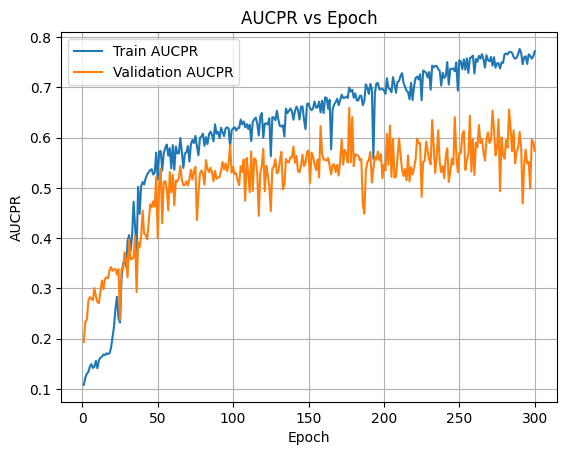

In [ ]:



plt.plot(range(1, epochs + 1), train_aucprs, label='Train AUCPR')
plt.plot(range(1, epochs + 1), val_aucprs, label='Validation AUCPR')


plt.xlabel("Epoch")
plt.ylabel("AUCPR")
plt.title("AUCPR vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

Starting around epoch 100, the validation AUCPR score levels off while the training AUCPR continues to rise, indicating the onset of overfitting.

b.	Retrain the same GCN model, but add an early stopping criterion using the AUCPR calculated over the validation set. Report the performance on the test set. How does it compare to the feature-based model?

In [ ]:
import copy

train_aucprs = []
val_aucprs = []
best_val_aucpr = 0
epochs_no_improve = 0
patience = 20

model = GCN(hidden_channels=64).to(device)   # Start a new model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = torch.nn.CrossEntropyLoss()


epochs = 300
for epoch in range(1, epochs + 1):
    train()
    train_aucpr = compute_aucpr(train_loader, model)
    val_aucpr = compute_aucpr(validation_loader, model)
    train_aucprs.append(train_aucpr)
    val_aucprs.append(val_aucpr)
    if epoch % 30 == 0:
      print(f'Epoch {epoch:03d}: Train AUCPR = {train_aucpr:.4f}, Val AUCPR = {val_aucpr:.4f}')
    if val_aucpr > best_val_aucpr + 1e-2:
        best_val_aucpr = val_aucpr
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience and epoch > 90:
        print(f"Early stopping at epoch {epoch}. Best Val AUCPR = {best_val_aucpr:.4f}, epoch = {epoch -patience}")
        break

# Restore best model
model.load_state_dict(best_model_state)


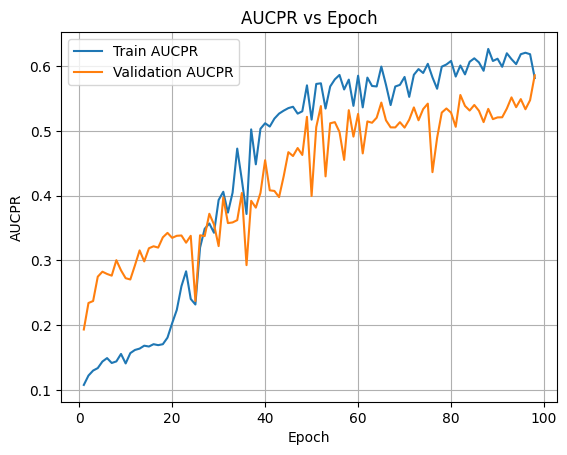

In [ ]:


cutoff = 20
epochs = range(1, len(train_aucprs) - cutoff + 1)

# Plot original AUCPR curves
plt.plot(epochs, train_aucprs[:-cutoff], label='Train AUCPR')
plt.plot(epochs, val_aucprs[:-cutoff], label='Validation AUCPR')


plt.xlabel("Epoch")
plt.ylabel("AUCPR")
plt.title("AUCPR vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

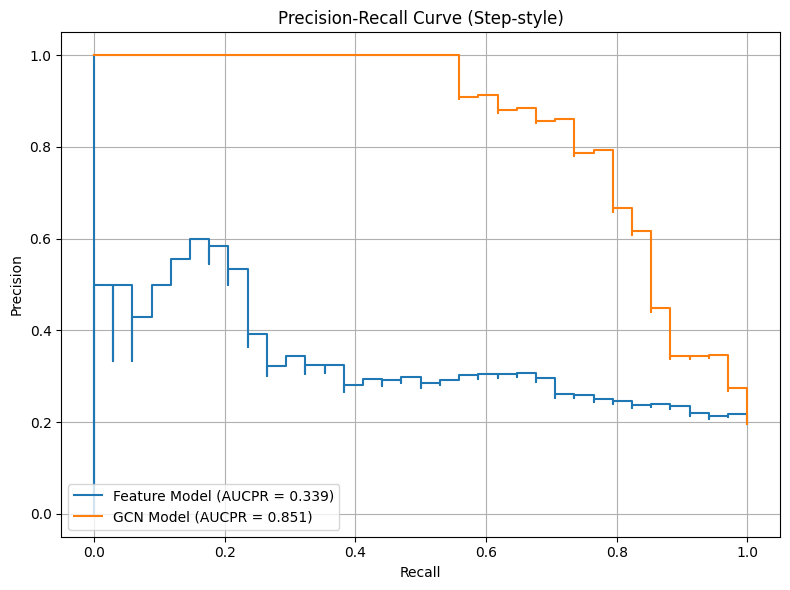

In [ ]:
true_labels = table_first_round_molecules['Class_Label'].iloc[test_index]
feature_model_proba = best_model.predict_proba(X_test)[:, 1]
feature_precision, feature_recall, _ = precision_recall_curve(true_labels, feature_model_proba)
feature_model_aucpr = average_precision_score(true_labels, feature_model_proba)




# GCN model
gcn_model = model
gcn_model.eval()
gcn_model_proba = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = gcn_model(data.x, data.edge_attr, data.edge_index, data.batch)
        probs = out.softmax(dim=1)  # Assumes binary classification (2 classes)
        gcn_model_proba.append(probs.cpu())

gcn_model_proba = torch.cat(gcn_model_proba).numpy()
gcn_model_positive_proba = gcn_model_proba[:, 1]  # Take probability of the positive class

gcn_precision, gcn_recall, _ = precision_recall_curve(true_labels, gcn_model_positive_proba)
gcn_model_aucpr = average_precision_score(true_labels, gcn_model_positive_proba)


# --- Plotting ---
plt.figure(figsize=(8, 6))
plt.step(feature_recall, feature_precision, where='post', label=f'Feature Model (AUCPR = {feature_model_aucpr:.3f})')
plt.step(gcn_recall, gcn_precision, where='post', label=f'GCN Model (AUCPR = {gcn_model_aucpr:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Step-style)')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

The precision-recall curve comparison clearly shows that the GCN model significantly outperforms the Feature model. The area under the precision-recall curve (AUCPR) for the GCN model is 0.851, while the Feature model reaches only 0.382, indicating a substantial difference in performance. The GCN model maintains high precision across a wide range of recall values, remaining above 0.8 until approximately 0.8 recall, which reflects its ability to make confident and accurate positive predictions even as it identifies more true positives. In contrast, the Feature model demonstrates low and unstable precision, with frequent drops and fluctuations, suggesting a higher rate of false positives and overall less reliable predictions. The smoother curve of the GCN model also indicates greater stability and a better balance between precision-recall. These results highlight the advantage of the GCN model, likely enabling it to capture richer contextual information compared to the Feature model, which relies only on individual input features.

12.	How many parameters does the GCN have, as function of the number of layers and of the dimension of the node features?

# Model Parameter Calculation

Let:

- $d$: Input feature dimension (raw node features)  
- $L$: Number of GCN layers  
- $h_0$: Output dimension of the input embedding layer  
- $h_i$: Input dimension of GCN layer $i$  
- $h_L$: Output dimension of the last GCN layer (input to classifier)  

---

### Model Architecture

**1. Input Layer** — $\text{Linear}(d \rightarrow h_0)$

**Parameters:**

$$
(d + 1) \cdot h_0
$$

---

**2. GCN Layers** — $\text{GCNConv}(h_i \rightarrow h_{i+1})$ for $i = 0, \dots, L - 1$

Each layer has:

$$
(h_i + 1) \cdot h_{i+1}
$$

Total GCN parameters:

$$
\sum_{i=0}^{L-1} (h_i + 1) \cdot h_{i+1}
$$

---

**3. Output Layer** — $\text{Linear}(h_L \rightarrow 2)$

**Parameters:**

$$
(h_L + 1) \cdot 2
$$

---

### Total Number of Parameters

$$
(d + 1) \cdot h_0 + \left( \sum_{i=0}^{L-1} (h_i + 1) \cdot h_{i+1} \right) + 2 \cdot (h_L + 1)
$$

---

### Special Case: Fixed Hidden Dimension $h$

Assume:

- All GCN layers use the same hidden dimension $h$  
- Input layer maps: $d \rightarrow h$  
- GCN layers: $h \rightarrow h$  
- Output layer: $h \rightarrow 2$  

Then:

**Input layer:**

$$
(d + 1) \cdot h
$$

**GCN layers:**

$$
L \cdot (h + 1) \cdot h
$$

**Output layer:**

$$
(h + 1) \cdot 2
$$

---

### Total Parameters (Fixed $h$):

$$
(d + 1) \cdot h + L \cdot (h + 1) \cdot h + 2 \cdot (h + 1)
$$


13.	Varying the network width: Train GCNs with varying node feature dimensions ([16,32,64,128] ) and plot the learning curves of the model (loss vs number of epochs) on the training and validation sets. Are there signs of overfitting? Why?



In [ ]:
d = [2**i for i in range(4, 8)]  # [16, 32, 64, 128]
epochs = 300

train_results_dim_task = {}
val_results_dim_task = {}

for dim in d:
    train_aucprs = []
    val_aucprs = []

    model = GCN(hidden_channels=dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_function = torch.nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        train()
        train_aucpr = compute_aucpr(train_loader, model)
        val_aucpr = compute_aucpr(validation_loader, model)
        train_aucprs.append(train_aucpr)
        val_aucprs.append(val_aucpr)

        if epoch % 30 == 0:
            print(f'Dim {dim} - Epoch {epoch:03d}: Train AUCPR = {train_aucpr:.4f}, Val AUCPR = {val_aucpr:.4f}')

    train_results_dim_task[dim] = train_aucprs
    val_results_dim_task[dim] = val_aucprs

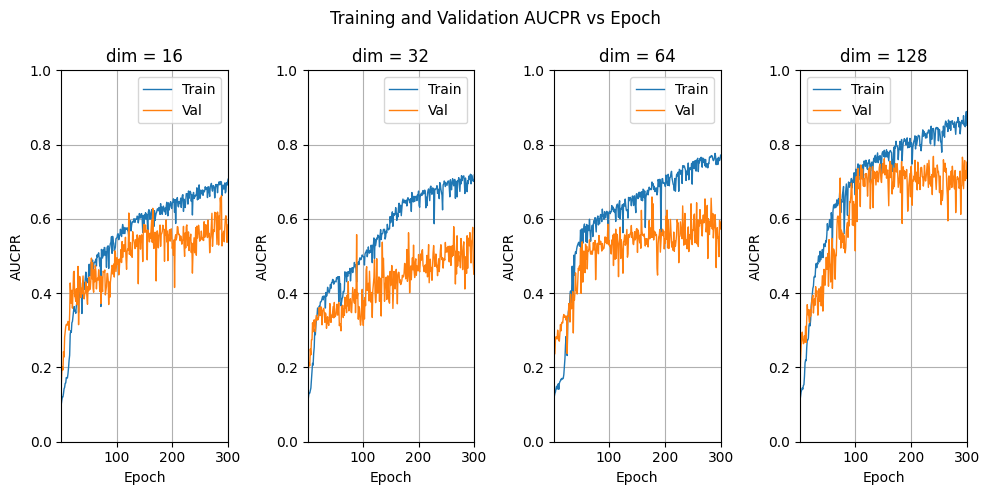

In [ ]:
# --- Plotting ---
fig, axes = plt.subplots(1, len(d), figsize=(10, 5))

# Plot training curves
for i, dim in enumerate(d):

    epochs_range = range(1, epochs + 1)
    axes[i].plot(epochs_range, train_results_dim_task[dim], label=f"Train", linewidth=1)
    axes[i].plot(epochs_range, val_results_dim_task[dim], label=f"Val", linewidth=1)

    axes[i].set_title(f"dim = {dim}")
    axes[i].set_xlabel("Epoch")
    axes[i].set_ylabel("AUCPR")
    axes[i].set_xlim(1, epochs)
    axes[i].set_ylim(0, 1)
    axes[i].grid(True)
    axes[i].legend()

plt.suptitle("Training and Validation AUCPR vs Epoch")

plt.tight_layout()
plt.show()


he training and validation AUCPR trends across different embedding dimensions reveal varying degrees of overfitting. At lower dimensions (e.g., dim = 16), both training and validation AUCPR increase steadily with minimal divergence, indicating good generalization and little to no overfitting. Dim = 32 shows slightly more separation between the curves, especially after epoch 150, but validation performance continues to improve, suggesting only mild overfitting.

In contrast, higher-dimensional models (dim = 64 and 128) show a growing gap between training and validation AUCPR. For dim = 64, training AUCPR keeps increasing while validation AUCPR plateaus. This effect is stronger in dim = 128, where validation performance peaks early and then declines, suggesting reduced generalization.

That said, higher-dimensional models may also just learn faster due to their greater capacity. The model could just be reaching its best performance earlier. In this case, early stopping will be enough.

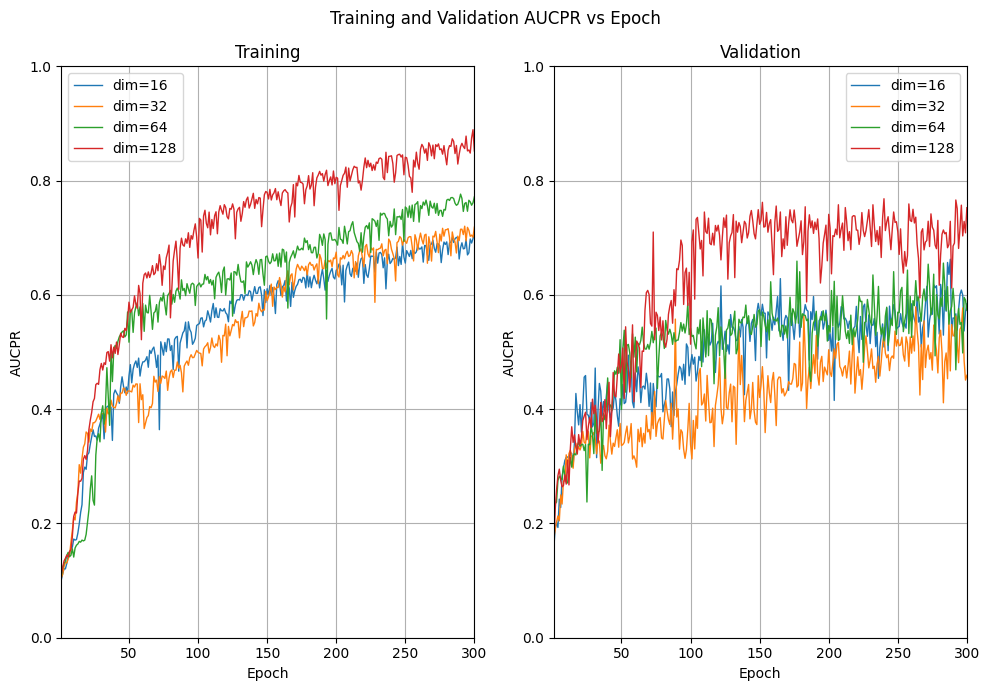

In [ ]:
# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(10, 7))

# Plot training curves
for dim in d:

    epochs_range = range(1, epochs + 1)
    axes[0].plot(epochs_range, train_results_dim_task[dim], label=f"dim={dim}", linewidth=1)

axes[0].set_title("Training")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("AUCPR")
axes[0].set_xlim(1, epochs)
axes[0].set_ylim(0, 1)
axes[0].grid(True)
axes[0].legend()

# Plot validation curves
for dim in d:

    epochs_range = range(1, epochs + 1)
    axes[1].plot(epochs_range, val_results_dim_task[dim], label=f"dim={dim}",linewidth=1)

axes[1].set_title("Validation")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("AUCPR")
axes[1].set_xlim(1, epochs)
axes[1].set_ylim(0, 1)
axes[1].grid(True)
axes[1].legend()

plt.suptitle("Training and Validation AUCPR vs Epoch")
plt.tight_layout()
plt.show()


The 64-dimensional model provides the best balance between performance and generalization, achieving high validation AUCPR with minimal overfitting. Although the 128-dimensional model reaches a higher peak AUCPR, it shows signs of overfitting early, likely due to excess model capacity. Models with 16 and 32 dimensions underperform. To assess whether the additional complexity of 128 is justified, we will include both 64 and 128 dimensions in the model depth selection stage.

14.	Varying the network depth and the oversmoothing effect: Train GCNs with varying number of layers ([1, 3,5,10]), and (approximately) fixed number of parameters, and plot the learning curves of the model. Are there signs of overfitting? Underfitting? Why?

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import torch


class GCN_V2(torch.nn.Module):
    def __init__(self, hidden_channels, depth):
        super(GCN_V2, self).__init__()
        torch.manual_seed(12345)



        # Initialize the layers
        self.node_embedding = Linear(dataset.num_node_features, hidden_channels)
        self.convs = torch.nn.ModuleList([
            GCNConv(hidden_channels, hidden_channels) for _ in range(depth)
        ])
        self.lin = Linear(hidden_channels, 2) # Here, only two classes


    def forward(self, node_features, edge_features, edge_index, batch):

        # 1. Embed node features
        x = self.node_embedding(node_features)
        x = x.relu()

        # 2. Pass through a [permutation-equivariant] GCN layer

        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)  # ReLU after each conv

        # 3. Global average pooling for obtaining a permutation-invariant representation.
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 4. Apply a final classifier
        x = self.lin(x) # This is the pre-sigmoid output.
        return x

def train():
    model.train()
    for data in train_loader:
        data = data.to(device)  # Move batch to GPU
        out = model(data.x, data.edge_attr, data.edge_index, data.batch)
        loss = loss_function(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()



def compute_aucpr(loader, model_to_use):
    model_to_use.eval()
    y_true = []
    y_score = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model_to_use(data.x, data.edge_attr, data.edge_index, data.batch)
            probs = out.softmax(dim=1)
            y_score.append(probs.cpu())        # move to CPU for sklearn
            y_true.append(data.y.cpu())        # move to CPU

    y_score = torch.cat(y_score).numpy()
    y_true = torch.cat(y_true).numpy()

    return average_precision_score(y_true, y_score[:, 1])



In [ ]:
d = [1,3,5,10]
dims = [64,128]


epochs = 300

train_results_depth_task = {}
val_results_depth_task = {}

for depth in d:
  for dim in dims:
    train_aucprs = []
    val_aucprs = []

    model = GCN_V2(dim, depth).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_function = torch.nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        train()
        train_aucpr = compute_aucpr(train_loader, model)
        val_aucpr = compute_aucpr(validation_loader, model)
        train_aucprs.append(train_aucpr)
        val_aucprs.append(val_aucpr)

        if epoch % 30 == 0:
            print(f'Dim {dim}, depth {depth} - Epoch {epoch:03d}: Train AUCPR = {train_aucpr:.4f}, Val AUCPR = {val_aucpr:.4f}')

    train_results_depth_task[(dim, depth)] = train_aucprs
    val_results_depth_task[(dim, depth)] = val_aucprs

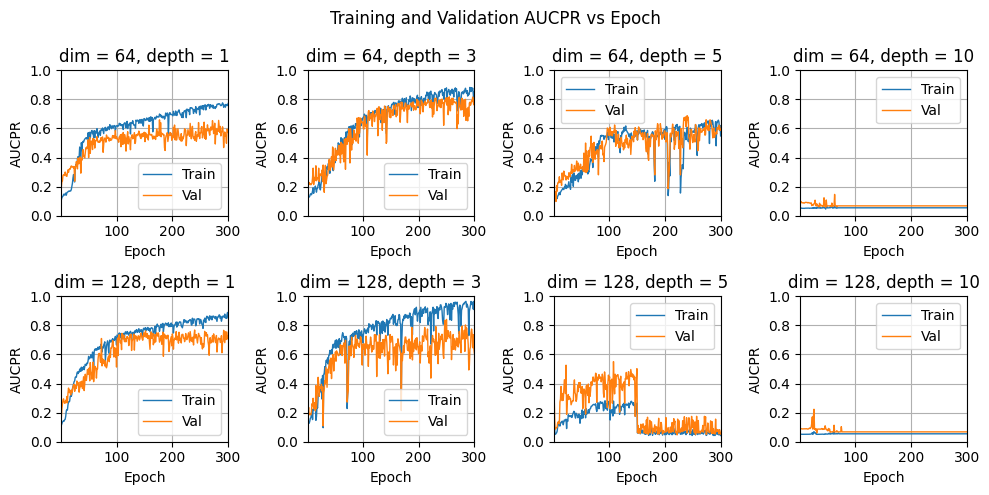

In [ ]:
# --- Plotting ---
fig, axes = plt.subplots(len(dims), len(d), figsize=(10, 5))

# Plot training curves
for j, dim in enumerate(dims):
  for i, depth in enumerate(d):

    epochs_range = range(1, epochs + 1)
    axes[j, i].plot(epochs_range, train_results_depth_task[(dim, depth)], label=f"Train", linewidth=1)
    axes[j, i].plot(epochs_range, val_results_depth_task[(dim, depth)], label=f"Val", linewidth=1)

    axes[j, i].set_title(f"dim = {dim}, depth = {depth}")
    axes[j, i].set_xlabel("Epoch")
    axes[j, i].set_ylabel("AUCPR")
    axes[j, i].set_ylim(0,1)
    axes[j, i].set_xlim(1, epochs)
    axes[j, i].grid(True)
    axes[j, i].legend()

plt.suptitle("Training and Validation AUCPR vs Epoch")

plt.tight_layout()

Models with shallow depths (1 or 3) demonstrate effective learning and stable generalization by balancing receptive field size and feature preservation. For instance, a model with dim=128 and depth=1 reaches high training (0.85) and validation (0.76) AUCPRs, while one with dim=64 and depth=3 performs reliably with minimal overfitting. These models are sufficiently deep to gather significant neighborhood information, yet not so deep that they lose node-specific features.

In contrast, deeper models (depth = 5 or 10) suffer from over-smoothing, which occurs in GCNs when repeated message passing causes node embeddings to converge to similar values, making them indistinguishable. This leads to a collapse in both training and validation performance. At depth 5, especially for models with higher dimensions (such as dim=128), they begin to lose discriminative power, with sharp AUCPR drops after epoch 150. At depth 10, all models fail entirely, with flat AUCPRs near zero, confirming that excessive depth in GCNs without architectural corrections such as residual connections or normalization causes the network to lose its ability to learn distinct node representations.


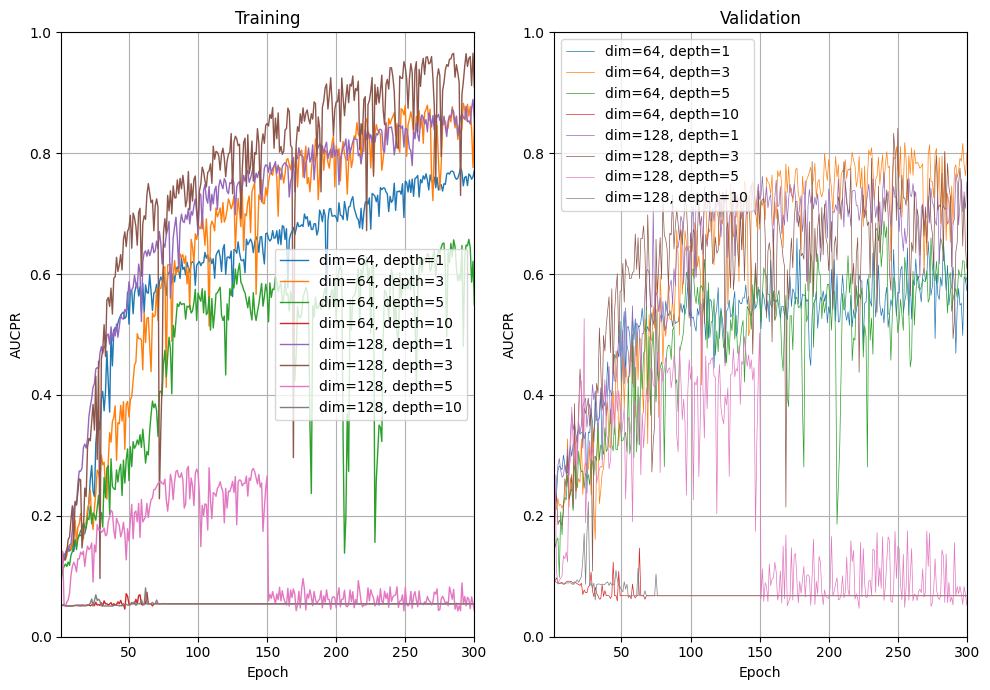

In [ ]:
# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(10, 7))

# Plot training curves
for dim in dims:
    for depth in d:

        axes[0].plot(epochs_range, train_results_depth_task[(dim, depth)], label=f"dim={dim}, depth={depth}", linewidth=1)

axes[0].set_title("Training")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("AUCPR")
axes[0].set_xlim(1, epochs)
axes[0].set_ylim(0, 1)
axes[0].grid(True)
axes[0].legend()

# Plot validation curves
for dim in dims:
    for depth in d:
        epochs_range = range(1, epochs + 1)
        axes[1].plot(epochs_range, val_results_depth_task[(dim, depth)], label=f"dim={dim}, depth={depth}", linewidth=0.5)

axes[1].set_title("Validation")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("AUCPR")
axes[1].set_xlim(1, epochs)
axes[1].set_ylim(0, 1)
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


 By plotting training and validation curves for all configurations together we can compare performances. It confirms that dim=64, depth=3 strikes the best balance, while deeper models diverge or collapse.

15.	Virtual screening: Pick the best GNN, and use it to predict antimicrobial activity on the evaluation set. How do the predictions correlate with the ones of the D-MPNN model? Does it predict halicin to have an activity?

In [ ]:
best_dim = 64
best_depth = 3


train_aucprs_best_model = []
val_aucprs_best_model = []
best_val_aucpr = 0
epochs_no_improve = 0
patience = 30

model = GCN_V2(hidden_channels=best_dim, depth=best_depth).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = torch.nn.CrossEntropyLoss()


epochs = 300
for epoch in range(1, epochs + 1):
    train()
    train_aucpr = compute_aucpr(train_loader, model)
    val_aucpr = compute_aucpr(validation_loader, model)
    train_aucprs_best_model.append(train_aucpr)
    val_aucprs_best_model.append(val_aucpr)
    if epoch % 30 == 0:
      print(f'Epoch {epoch:03d}: Train AUCPR = {train_aucpr:.4f}, Val AUCPR = {val_aucpr:.4f}')
    if val_aucpr > best_val_aucpr + 1e-2:
        best_val_aucpr = val_aucpr
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience and epoch > 140:
        print(f"Early stopping at epoch {epoch}. Best Val AUCPR = {best_val_aucpr:.4f}, epoch = {epoch -20}")
        break

# Restore best model
model.load_state_dict(best_model_state)


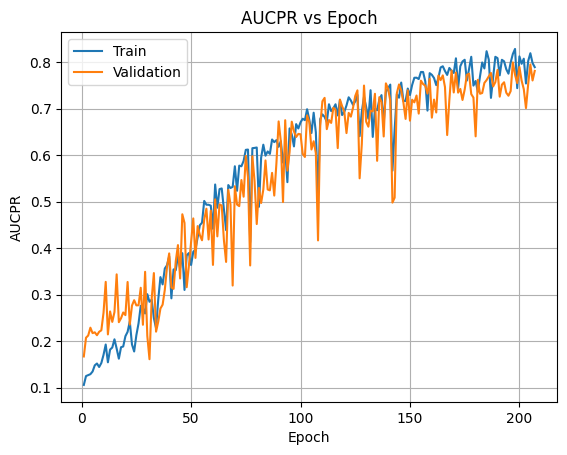

In [ ]:

cutoff = 20
epochs = range(1, len(train_aucprs_best_model) - cutoff + 1)

# Plot original AUCPR curves
plt.plot(epochs, train_aucprs_best_model[:-cutoff], label='Train')
plt.plot(epochs, val_aucprs_best_model[:-cutoff], label='Validation')


plt.xlabel("Epoch")
plt.ylabel("AUCPR")
plt.title("AUCPR vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

Test AUCPR: 0.8843, Acc: 0.9367816091954023


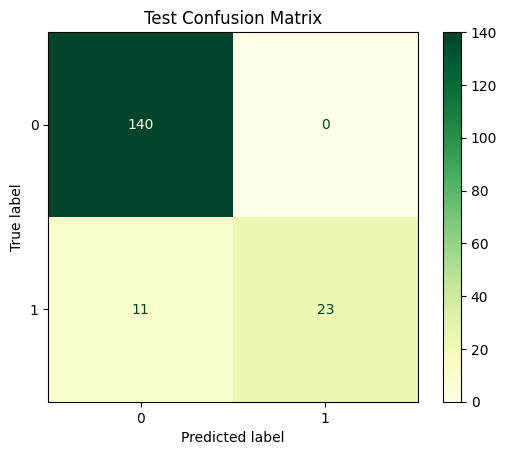

In [ ]:

test_aupcr = compute_aucpr(test_loader, model)
print(f"Test AUCPR: {test_aupcr:.4f}, Acc: {test(test_loader)}")

test_predictions = []
true_labels = []


model.eval()
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_attr, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        true_labels.extend(data.y.cpu().numpy())
        test_predictions.extend(pred.cpu().numpy())

ConfusionMatrixDisplay.from_predictions(true_labels, test_predictions, cmap=plt.cm.YlGn)
plt.title("Test Confusion Matrix")
plt.show()



In [ ]:


eval_predictions = []

DMPNN_predictions = table_evaluation_molecules["Pred_Score"]
molecule_names = table_evaluation_molecules["Name"].values


model.eval()
with torch.no_grad():
    for data in evaluation_loader:
        data = data.to(device)
        out = model(data.x, data.edge_attr, data.edge_index, data.batch)
        pred = out.softmax(dim=1)[:,1]
        eval_predictions.extend(pred.cpu().numpy())


df_compare = pd.DataFrame({"Name": molecule_names, "CGN_predictions": eval_predictions, "DMPNN_predictions": DMPNN_predictions})

print(f"halicin predicted activity (CGN): {eval_predictions[molecule_names.tolist().index('SU3327') +1]}")
print(f"halicin rank CGN = {(df_compare.sort_values(by='CGN_predictions', ascending=False)['Name']).tolist().index('SU3327')}")

print(f"halicin predicted activity(D-MPNN): {DMPNN_predictions[molecule_names.tolist().index('SU3327') + 1]}")

print(f"halicin rank D-MPNN = {(df_compare.sort_values(by='DMPNN_predictions', ascending=False)['Name']).tolist().index('SU3327')}")


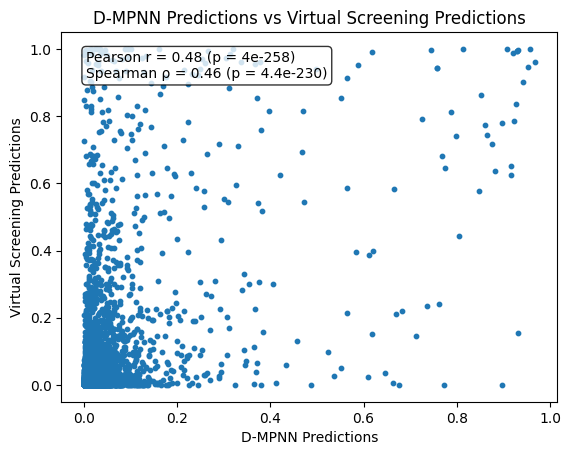

In [ ]:

from scipy.stats import pearsonr, spearmanr

# Calculate correlations
pearson_corr, pearson_pval = pearsonr(DMPNN_predictions, eval_predictions)
spearman_corr, spearman_pval = spearmanr(DMPNN_predictions, eval_predictions)
n = len(DMPNN_predictions)

# Create correlation label
label = (
    f"Pearson r = {pearson_corr:.2f} (p = {pearson_pval:.2g})\n"
    f"Spearman ρ = {spearman_corr:.2f} (p = {spearman_pval:.2g})"
)

# Plot
plt.scatter(DMPNN_predictions, np.array(eval_predictions), s=10)

plt.xlabel("D-MPNN Predictions")
plt.ylabel("Virtual Screening Predictions")
plt.title("D-MPNN Predictions vs Virtual Screening Predictions")
plt.annotate(label, xy=(0.05, 0.95), xycoords='axes fraction',
             ha='left', va='top', fontsize=10, bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))
plt.show()


When applied to the evaluation set of 4,496 molecules, the GCN model predicted halicin to have a reasonably high antimicrobial activity score of 0.6, ranking it 126th among all candidates. This indicates that the GCN model does predict halicin to be active, though not among the very top hits. In contrast, the D-MPNN model assigned halicin a lower activity score of 0.33 but gave it a higher rank of 88th, suggesting some differences in their internal scoring scales and compound prioritization. Overall, the GCN model’s predictions show a moderate correlation with those of the D-MPNN model (Pearson r = 0.48, Spearman ρ = 0.46), indicating partial agreement between the two models. This moderate correlation suggests that while there is some overlap in the patterns captured by the models, they may also be leveraging distinct features to inform their predictions

# Our Take on the Models

We observed that GCN achieves better results than a tree ensemble model in this task. We wanted to see whether fusing the models would lead to improved predictions.



In [ ]:
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm


class FusionModel():
    def __init__(self, hidden_channels, depth):
        super(FusionModel, self).__init__()
        torch.manual_seed(12345)
        self.hidden_channels = hidden_channels
        self.depth = depth
        self.GCN = GCN_V2(hidden_channels, depth)
        self.boosted_model = None

    def compute_probs_GCN(self, loader):
      self.GCN.eval()
      prob = []
      with torch.no_grad():
        for data in loader:
          data = data.to(device)
          out = self.GCN(data.x, data.edge_attr, data.edge_index, data.batch)
          probs = out.softmax(dim=1)[:, 1]
          prob.extend(probs.cpu().numpy())
        return np.array(prob)




    def train(self):
      self.GCN = GCN_V2(self.hidden_channels, self.depth)
      optimizer = torch.optim.Adam(self.GCN.parameters(), lr=0.01)
      loss_function = torch.nn.CrossEntropyLoss()

      train_aucprs_best_model = []
      val_aucprs_best_model = []
      best_val_aucpr = 0
      epochs_no_improve = 0
      patience = 30
      epochs = 300

      for epoch in tqdm(range(1, epochs + 1), "GCN epoch"):
        self.GCN.train()

        for data in train_loader:  # Iterate in batches over the training dataset.
         out = self.GCN(data.x, data.edge_attr, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = loss_function(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

        train_aucpr = compute_aucpr(train_loader, self.GCN)
        val_aucpr = compute_aucpr(validation_loader, self.GCN)
        train_aucprs_best_model.append(train_aucpr)
        val_aucprs_best_model.append(val_aucpr)


        if val_aucpr > best_val_aucpr + 1e-2:
          best_val_aucpr = val_aucpr
          best_model_state = copy.deepcopy(self.GCN.state_dict())
          epochs_no_improve = 0
        else:
          epochs_no_improve += 1

        if epochs_no_improve >= patience and epoch > 140:
          print(f"Early stopping at epoch {epoch}. Best Val AUCPR = {best_val_aucpr:.4f}, epoch = {epoch -20}")
          break

        # Restore best model
      self.GCN.load_state_dict(best_model_state)

      # train XGBoost model

      param_grid = {
          'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
          'clf__max_iter': [200, 300, 600, 900],
          'clf__max_leaf_nodes': [31, 63, 127, 255],
          'clf__min_samples_leaf': [10, 20, 50],
          'clf__l2_regularization': [0.0, 0.1, 1.0, 5.0, 10.0]
          }

      pipe = Pipeline([
          ('clf', HistGradientBoostingClassifier(random_state=0, class_weight='balanced'))
        ])
      best_score = -1
      best_params = None
      best_model = None
      train_preds = self.compute_probs_GCN(train_loader)
      val_preds = self.compute_probs_GCN(validation_loader)

      train_features = features_first_round_molecules.iloc[train_index].copy()
      val_features = features_first_round_molecules.iloc[val_index].copy()
      train_features['GNN_Pred'] = train_preds
      val_features['GNN_Pred'] = val_preds

      X_train = train_features
      y_train = table_first_round_molecules['Class_Label'].iloc[train_index]

      X_val = val_features
      y_val = table_first_round_molecules['Class_Label'].iloc[val_index]

      for params in tqdm(ParameterGrid(param_grid), desc="Hyperparameter tuning"):
        pipe.set_params(**params)
        pipe.fit(X_train, y_train)
        score = average_precision_score(y_val, pipe.predict_proba(X_val)[:, 1])
        if score > best_score:
          best_score = score
          best_params = params
          best_model = copy.deepcopy(pipe)

      print(f"Best parameters: {best_params}, Best AUCPR: {best_score:.4f}")
      self.boosted_model = best_model




    def predict(self):
        self.GCN.eval()

        test_preds = self.compute_probs_GCN(test_loader)
        test_features = features_first_round_molecules.iloc[test_index].copy()
        test_features['GNN_Pred'] = test_preds
        test_X = test_features

        return self.boosted_model.predict_proba(test_X)[:, 1]




In [ ]:
fusion = FusionModel(hidden_channels=64, depth=3)
fusion.train()
fused_model_proba = fusion.predict()
fusion_recall, fusion_precision, _ = precision_recall_curve(table_first_round_molecules['Class_Label'].iloc[test_index], fused_model_proba)
fusion_model_aucpr = average_precision_score(table_first_round_molecules['Class_Label'].iloc[test_index], fused_model_proba)



GCN epoch:  75%|███████▌  | 226/300 [06:04<01:59,  1.61s/it]

Early stopping at epoch 227. Best Val AUCPR = 0.7996, epoch = 207



Hyperparameter tuning: 100%|██████████| 960/960 [27:50<00:00,  1.74s/it]

Best parameters: {'clf__l2_regularization': 10.0, 'clf__learning_rate': 0.05, 'clf__max_iter': 600, 'clf__max_leaf_nodes': 31, 'clf__min_samples_leaf': 50}, Best AUCPR: 0.9047


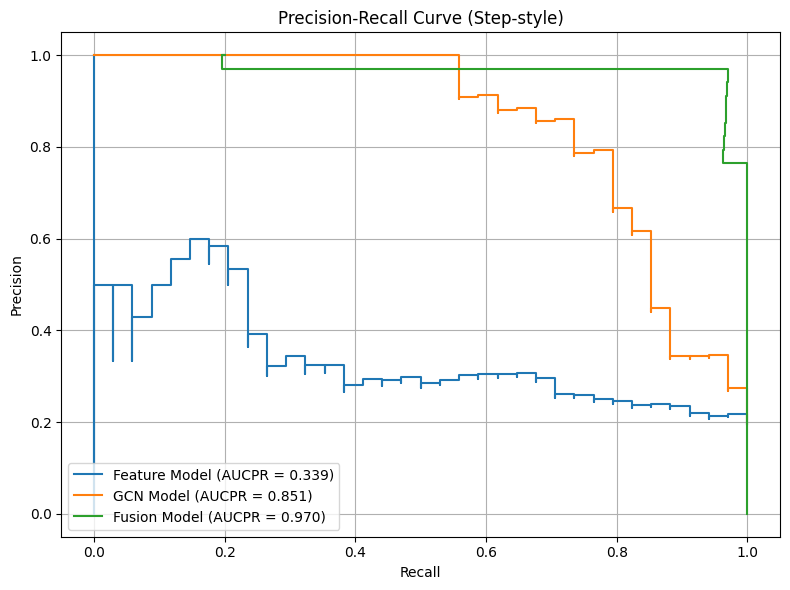

In [ ]:


# --- Plotting ---
plt.figure(figsize=(8, 6))
plt.step(feature_recall, feature_precision, where='post', label=f'Feature Model (AUCPR = {feature_model_aucpr:.3f})')
plt.step(gcn_recall, gcn_precision, where='post', label=f'GCN Model (AUCPR = {gcn_model_aucpr:.3f})')
plt.step(fusion_recall, fusion_precision, where='post', label=f'Fusion Model (AUCPR = {fusion_model_aucpr:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Step-style)')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

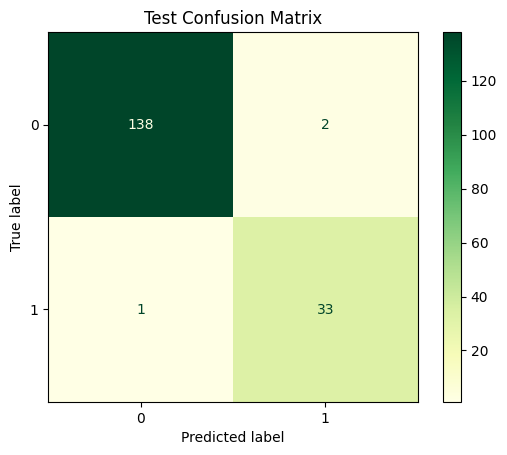

In [ ]:
fusion_preds = (fused_model_proba >= 0.5).astype(int)
ConfusionMatrixDisplay.from_predictions(true_labels, fusion_preds, cmap=plt.cm.YlGn)
plt.title("Test Confusion Matrix")
plt.show()


The test set results show that fusing the GCN and tree ensemble models significantly improves performance. While the GCN alone outperforms the feature-based model (AUPRC 0.851 vs. 0.339), the fusion model achieves the highest AUPRC of 0.970, indicating it effectively combines structural and feature information. The confusion matrix supports this, with high accuracy (98.8%), recall (97.1%), and precision (94.3%). Overall, fusion leads to better generalization and is the most effective approach for this task.